In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import csv
import seaborn as sns

COLUMNS = ['AMB', 'CH4', 'CO', 'NMHC', 'NO', 'NO2',
        'NOx', 'O3', 'PM10', 'PM2.5', 'RAINFALL', 'RH',
        'SO2', 'THC', 'WD_HR', 'WIND_DIR', 'WIND_SPEED', 'WS_HR']

# Read in training set

In [ ]:
def read_trainData(filename):
    # 讀入檔案
    raw_data = pd.read_csv(filename, header=None, encoding='utf8')

    # 去除標頭和多餘直行
    row, col = raw_data.shape
    raw_data  = raw_data.iloc[1:row, 3:col]              

    # 去除多餘空格
    raw_data = raw_data.replace(r'\s+', '', regex=True)  

    # 將特殊符號替換為 0
    special_chars = ['#', '*', 'x', 'A']  # 定義需要替換的特殊符號
    raw_data.replace(special_chars, 0.0, inplace=True)

    # 轉換成numpy & 浮點數型別
    data = raw_data.values 
    data = data.astype('float')

    month_to_data = {}  ## Dictionary (key:month , value:data)                                  

    # generate month_to_data(20 days data)
    for month in range(12):
        sample = np.empty(shape = (18 , 480))
        for day in range(20):
            for hour in range(24): 
                sample[:,day * 24 + hour] = data[18 * (month * 20 + day): 18 * (month * 20 + day + 1),hour]
        month_to_data[month] = sample  

    return month_to_data

# 繪製離散圖形

In [ ]:
# 讀入檔案
raw_data = pd.read_csv('../input_data/train.csv', header=None, encoding='utf8')

# 去除標頭和多餘直行
row, col = raw_data.shape
raw_data  = raw_data.iloc[1:row, 3:col]              

# 去除多餘空格
raw_data = raw_data.replace(r'\s+', '', regex=True)  

# 將特殊符號替換為 0
special_chars = ['#', '*', 'x', 'A']  # 定義需要替換的特殊符號
raw_data.replace(special_chars, 0.0, inplace=True)

# 轉換成numpy & 浮點數型別
data = raw_data.values 
data = data.astype('float')

X_g = []
Y_g = []

# 起始值:0 , 結束值: data.shape[0], 每次增加步長: 18*20
for month in range(0, data.shape[0], 18*20):
    # month: 第幾月份
    days = np.vsplit(data[month:month+18*20], 20) # shape: (18*24) *20 -> 數據按照行數分割成 20 天
    concat = np.concatenate(days, axis=1) # shape: (18 feature, 480(days*hr)) -> 將20天數據沿著水平方向拼接
    # print(concat.shape)
    for hour in range(0, concat.shape[1]):
        # hour: 第幾小時    
        features = concat[:, hour:hour+1].flatten() # 選取從第 j 小時到第 j+N 小時的數據
        # features = np.append(features, [1])   # 特徵向量的末尾添加一個 1，這是為了引入偏置項 w0     
        # print(features)
        X_g.append(features)
        Y_g.append([concat[9, hour]])             # 第 9 行（是feature PM2.5），目標值

X_g = np.array(X_g)
Y_g = np.array(Y_g)

print(X_g.shape)
print(Y_g.shape)

In [ ]:
MEAN_x = np.mean(X_g, axis = 0)   #计算每个属性的均值
STD_x = np.std(X_g, axis = 0)     #计算每个属性的方差

MEAN_y = np.mean(Y_g, axis = 0) 
STD_y = np.std(Y_g, axis = 0)  

X_g = X_g - MEAN_x
X_g = X_g / STD_x

Y_g = Y_g - MEAN_y
Y_g = Y_g / STD_y

print(X_g.shape)
print(Y_g.shape)

In [ ]:

import matplotlib.pyplot as plt

# 假設 X_g 和 Y_g 已經是 numpy 數組
# 這裡選擇 X_g 的第一列作為特徵
feature_index = 0  # 您可以選擇 0 到 17 之間的任意索引來查看不同的特徵

for feature_index in range(len(COLUMNS)):
    # 繪製散點圖
    plt.figure(figsize=(8, 6))
    plt.scatter(X_g[:, feature_index], Y_g, color='blue', alpha=0.5)
    plt.title(f'Scatter Plot of Feature {COLUMNS[feature_index]} vs Target')
    plt.xlabel(f'Feature {COLUMNS[feature_index]}')
    plt.ylabel('Target')
    plt.show()


# 分析圖

In [ ]:

def analysis_graph(month_to_data, top_n, threshold, method='top_n'):
    data_features = np.vstack([value.T for value in month_to_data.values()])

    df_data_features = pd.DataFrame(data_features, columns=COLUMNS)
    label = np.array(df_data_features['PM2.5'][9:])
    corr_matrix = df_data_features.corr()


    print(f"================= Feature Selection - {method} =================")
 
    # 获取与 'PM2.5' 的相关性
    pm25_corr = corr_matrix['PM2.5']   
    if method == 'top_n':
        # 排序并找出与 PM2.5 最相关的前 N 个特征
        top_n =  top_n # 设置要找出的前 N 个相关特征
        top_pm25 = pm25_corr.drop('PM2.5').sort_values(ascending=False).head(top_n)
        need_features = top_pm25 
        print(f"與 PM2.5 排名最的前 {top_n} 個特徵：")
        print(top_pm25)

    elif method == 'threshold':
        # 设置一个阈值筛选出高于该值的相关性特征
        threshold = threshold  # 设定阈值 0.3
        high_corr_features = pm25_corr[pm25_corr > threshold].drop('PM2.5').sort_values(ascending=False)
        need_features = high_corr_features 
        print(f"與 PM2.5 相關性大於 {threshold} 的特徵：")
        print(high_corr_features)

    print("================= analysis graph =================")
    f,ax = plt.subplots(figsize=(9,6))
    sns.heatmap(corr_matrix, fmt='.3f', linewidths=0.5, ax=ax, cmap='coolwarm')
    plt.show()
    
    need_features = need_features.index.tolist() 
    return need_features


# Preprocess

In [ ]:

def select_features(month_to_data, need_feature_index):
    # 遍历字典并保留每个数组中的指定行
    for key, value in month_to_data.items():
        # 保留指定的行索引
        month_to_data[key] = value[need_feature_index, :]
        
    return month_to_data


In [ ]:
def SetDataSets(month_to_data, feature_num, PM25_index):
    x = np.empty(shape = (12 * 471 , feature_num * 9 * 2),dtype = float)
    y = np.empty(shape = (12 * 471 , 1),dtype = float)

    for month in range(12): 
        for day in range(20): 
            for hour in range(24):   
                if day == 19 and hour > 14:
                    continue  
                x1 = month_to_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1,-1) 
                x[month * 471 + day * 24 + hour,:feature_num * 9] = x1 
                # 加入x的二次項
                x[month * 471 + day * 24 + hour, feature_num * 9 : feature_num * 9 * 2] = np.power(x1, 2)
                y[month * 471 + day * 24 + hour,0] = month_to_data[month][PM25_index ,day * 24 + hour + 9]
    return x, y


In [ ]:
def Normalization(x, mean, std):
    x = x - mean
    x = x / std
    return x    


# Linear Regression Agrad

In [ ]:
def RMSE(predict_Y, real_Y):
    N = len(predict_Y)  # 樣本數量
    loss = np.sqrt(np.sum((predict_Y - real_Y)**2) / N)
    return loss


In [ ]:


# L2 正則化（Ridge）
def traininig_L2(train_X, train_Y, valid_X, valid_Y, epochs, lambda_reg=0.1):
    dim = train_X.shape[1]
    w = np.zeros(shape=(dim, 1))
    learning_rate = np.array([[0.1]] * dim)
    adagrad_sum = np.zeros(shape=(dim, 1))  
    epoch = epochs
    loss_history = np.zeros([epoch, 1])
    loss_val_history = np.zeros([epoch, 1])
    min_loss_val = 0
    print("================= traininig L2 =================")
    
    for T in range(epoch):
        predict_Y = train_X.dot(w)   
        rmse_loss = RMSE(predict_Y, train_Y) + lambda_reg * np.sum(w ** 2)  # L2 正則化項
        loss_history[T] = rmse_loss
        
        # 紀錄驗證集變化
        pre = np.dot(valid_X, w)
        loss_val_history[T] = RMSE(pre, valid_Y) + lambda_reg * np.sum(w ** 2)  # L2 正則化項
        
        if T % 500 == 0:
            print(f"T={T}, Training Loss: {rmse_loss:.4f}, Validation Loss: {loss_val_history[T][0]:.4f}")
        
        if T == 0 or min_loss_val > loss_val_history[T][0]:
            min_loss_val = loss_val_history[T][0]
            np.save(f'weight_L2.npy', w)
            
        # Compute gradient (MSE gradient)
        gradient = 2 * np.dot(np.transpose(train_X), (predict_Y - train_Y)) / len(train_Y)
        
        # Add L2 regularization gradient
        gradient += 2 * lambda_reg * w  # L2 正則化項的梯度
        
        # Update Adagrad sum
        adagrad_sum += gradient ** 2
        Sigma = np.sqrt(adagrad_sum)
     
        # Update weights using Adagrad
        w = w - learning_rate * gradient / (Sigma + 0.0005)

    print(f"T={epochs-1}, Training Loss: {rmse_loss:.4f}, Validation Loss: {loss_val_history[epochs-1][0]:.4f}")
    
    return loss_history, loss_val_history


# L1 正則化（Lasso）
def traininig_L1(train_X, train_Y, valid_X, valid_Y, epochs, lambda_reg=0.1):
    dim = train_X.shape[1]
    w = np.zeros(shape=(dim, 1))
    learning_rate = np.array([[0.1]] * dim)
    adagrad_sum = np.zeros(shape=(dim, 1))  
    epoch = epochs
    loss_history = np.zeros([epoch, 1])
    loss_val_history = np.zeros([epoch, 1])
    min_loss_val = 0
    print("================= traininig L1 =================")
    
    for T in range(epoch):
        predict_Y = train_X.dot(w)   
        rmse_loss = RMSE(predict_Y, train_Y) + lambda_reg * np.sum(np.abs(w))  # L1 正則化項
        loss_history[T] = rmse_loss
        
        # 紀錄驗證集變化
        pre = np.dot(valid_X, w)
        loss_val_history[T] = RMSE(pre, valid_Y) + lambda_reg * np.sum(np.abs(w))  # L1 正則化項
        
        if T % 500 == 0:
            print(f"T={T}, Training Loss: {rmse_loss:.4f}, Validation Loss: {loss_val_history[T][0]:.4f}")
        
        if T == 0 or min_loss_val > loss_val_history[T][0]:
            min_loss_val = loss_val_history[T][0]
            np.save(f'weight_L1.npy', w)
            
        # Compute gradient (MSE gradient)
        gradient = 2 * np.dot(np.transpose(train_X), (predict_Y - train_Y)) / len(train_Y)
        
        # Add L1 regularization gradient
        gradient += lambda_reg * np.sign(w)  # L1 正則化項的梯度
        
        # Update Adagrad sum
        adagrad_sum += gradient ** 2
        Sigma = np.sqrt(adagrad_sum)
     
        # Update weights using Adagrad
        w = w - learning_rate * gradient / (Sigma + 0.0005)

    print(f"T={epochs-1}, Training Loss: {rmse_loss:.4f}, Validation Loss: {loss_val_history[epochs-1][0]:.4f}")
    
    return loss_history, loss_val_history



# ElasticNet 正則化
def traininig_ElasticNet(train_X, train_Y, valid_X, valid_Y, epochs, lambda_l1=0.1, lambda_l2=0.1):
    dim = train_X.shape[1]
    w = np.zeros(shape=(dim, 1))
    learning_rate = np.array([[0.1]] * dim)
    adagrad_sum = np.zeros(shape=(dim, 1))  
    epoch = epochs
    loss_history = np.zeros([epoch, 1])
    loss_val_history = np.zeros([epoch, 1])
    min_loss_val = 0
    print("================= traininig ElasticNet =================")
    
    for T in range(epoch):
        predict_Y = train_X.dot(w)   
        rmse_loss = RMSE(predict_Y, train_Y) + lambda_l1 * np.sum(np.abs(w)) + lambda_l2 * np.sum(w ** 2)  # ElasticNet 正則化項
        loss_history[T] = rmse_loss
        
        # 紀錄驗證集變化
        pre = np.dot(valid_X, w)
        loss_val_history[T] = RMSE(pre, valid_Y) + lambda_l1 * np.sum(np.abs(w)) + lambda_l2 * np.sum(w ** 2)  # ElasticNet 正則化項
        
        if T % 500 == 0:
            print(f"T={T}, Training Loss: {rmse_loss:.4f}, Validation Loss: {loss_val_history[T][0]:.4f}")
        
        if T == 0 or min_loss_val > loss_val_history[T][0]:
            min_loss_val = loss_val_history[T][0]
            np.save(f'weight_ElasticNet.npy', w)
            
        # Compute gradient (MSE gradient)
        gradient = 2 * np.dot(np.transpose(train_X), (predict_Y - train_Y)) / len(train_Y)
        
        # Add ElasticNet regularization gradient
        gradient += lambda_l1 * np.sign(w) + 2 * lambda_l2 * w  # ElasticNet 正則化項的梯度
        
        # Update Adagrad sum
        adagrad_sum += gradient ** 2
        Sigma = np.sqrt(adagrad_sum)
     
        # Update weights using Adagrad
        w = w - learning_rate * gradient / (Sigma + 0.0005)

    print(f"T={epochs-1}, Training Loss: {rmse_loss:.4f}, Validation Loss: {loss_val_history[epochs-1][0]:.4f}")
    
    return loss_history, loss_val_history


In [ ]:
def graph_val_Train(epochs, loss_history, loss_val_history):
    epoch = np.arange(epochs)
    plt.plot(epoch, loss_history)
    plt.plot(epoch, loss_val_history) 
    plt.show()

# predict valid

In [ ]:
def validation(valid_X, valid_Y, weightPath):
    w = np.load(weightPath) 
    print(w.shape)  
    valid_predict_Y = valid_X.dot(w)

    predict_rmse = RMSE(valid_predict_Y, valid_Y)
    print("================= validation =================")
    for i in range(len(valid_Y)):
        print(f"predict_Y[i], Y[i]: {np.round(valid_predict_Y[i], 0)}, {valid_Y[i]}")
        
    print(f"predict_rmse: {predict_rmse}")
    return predict_rmse
    


# Read in Testing set

In [ ]:
def read_testData(filename, feautre_num, need_feature_index):
    # 讀入檔案
    raw_data = pd.read_csv(filename, header=None, encoding='utf8')

    # 去除標頭和多餘直行
    row, col = raw_data.shape
    raw_data  = raw_data.iloc[:, 2:col]              

    # 去除多餘空格
    raw_data = raw_data.replace(r'\s+', '', regex=True)  

    # 將特殊符號替換為 0
    special_chars = ['#', '*', 'x', 'A','WIND_DIR+D2070EC']  # 定義需要替換的特殊符號
    raw_data.replace(special_chars, 0.0, inplace=True)
    
    # 轉換成numpy & 浮點數型別
    data = raw_data.values 
    data = data.astype('float')

    test_row = 244
    test_x = np.empty(shape = (test_row, feautre_num * 9 * 2),dtype = float)

    for i in range(test_row):
        features_arr = data[18 * i : 18 * (i+1),:]
        clean_features = features_arr[need_feature_index, :].reshape(1, -1)
        test_x[i, :feautre_num * 9] = clean_features
        test_x[i, feautre_num * 9:] = np.power(clean_features, 2)


    return test_x


# predict test

In [ ]:
def write_result(predict_Y, weightPath):
    name = weightPath.split('.')[0]
    name = name.split('_')[1]
    with open(f'../output/result_{name}.csv', "w", newline='') as f:
        w = csv.writer(f)
        title = ['index','answer']
        w.writerow(title) 
        for i in range(244):
            content = ['index_'+str(i),int(np.round(predict_Y[i][0], 0))]
            w.writerow(content) 
    
    print("write complete!")

In [ ]:
def testing(input_test_path, weightPath, feautre_num, need_feature_index, mean, std):
    test_X = read_testData(input_test_path, feautre_num, need_feature_index) 
    test_X = Normalization(test_X, mean, std)
    test_X = np.concatenate((np.ones(shape = (test_X.shape[0],1)),test_X),axis = 1).astype(float)

    print("================= testing =================")
    w = np.load(weightPath) 
    predict_Y = test_X.dot(w)
    write_result(predict_Y, weightPath)
 

In [ ]:
def save_diff_top_n_graph(valid_predict):
    x = np.arange(1,18)
    y = valid_predict
    plt.plot(x, y, 'ro--', linewidth=2, markersize=4)
    plt.savefig('../output/diff_top_n.png')
    plt.show()

def save_diff_test_size_graph(valid_predict):
    x = np.arange(0.5, 1, 0.1)
    y = valid_predict
    plt.plot(x, y, 'r*--', linewidth=1, markersize=4)
    plt.savefig('../output/diff_training_DataSets.png')
    plt.show()
    
    for i in range(len(x)):
        print(f"DataSets: {round(x[i], 1)}, valid_predict: {valid_predict[i]}")


# main

================= Feature Selection - threshold =================
與 PM2.5 相關性大於 0.2 的特徵：
PM10    0.816310
CO      0.600925
NMHC    0.511133
NO2     0.499470
NOx     0.463238
THC     0.303378
SO2     0.297900
NO      0.233854
CH4     0.218112
Name: PM2.5, dtype: float64
================= analysis graph =================


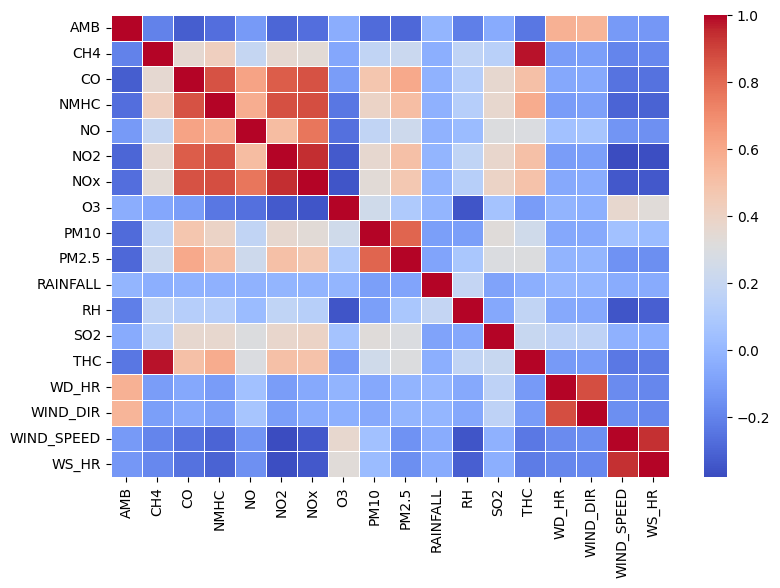

================= traininig ElasticNet =================
T=0, Training Loss: 16.8256, Validation Loss: 16.9989
T=500, Training Loss: 15.4854, Validation Loss: 15.4614
T=1000, Training Loss: 15.8273, Validation Loss: 15.8525
T=1500, Training Loss: 16.3320, Validation Loss: 16.3927
T=2000, Training Loss: 16.8926, Validation Loss: 16.9805
T=2500, Training Loss: 17.4673, Validation Loss: 17.5790
T=3000, Training Loss: 18.0334, Validation Loss: 18.1707
T=3500, Training Loss: 18.5790, Validation Loss: 18.7394
T=4000, Training Loss: 19.0948, Validation Loss: 19.2749
T=4500, Training Loss: 19.5785, Validation Loss: 19.7772
T=5000, Training Loss: 20.0297, Validation Loss: 20.2457
T=5500, Training Loss: 20.4449, Validation Loss: 20.6774
T=6000, Training Loss: 20.8302, Validation Loss: 21.0781
T=6500, Training Loss: 21.1786, Validation Loss: 21.4387
T=7000, Training Loss: 21.4970, Validation Loss: 21.7684
T=7500, Training Loss: 21.7868, Validation Loss: 22.0683
T=8000, Training Loss: 22.0480, Val

In [ ]:
if __name__=='__main__':
    input_train_path = '../input_data/train.csv'
    input_test_path = '../input_data/test.csv'    
    valid_predict = []

    month_to_data = read_trainData(input_train_path)
    need_features = analysis_graph(month_to_data, top_n=6, threshold=0.2, method='threshold')
    
    need_feature_index = sorted([COLUMNS.index(feature) for feature in need_features]) + [9] # add PM2.5
    month_to_data = select_features(month_to_data, need_feature_index)
    
    FEATURE_NUM = len(need_feature_index)
    PM25_INDEX = FEATURE_NUM - 1

    x, y = SetDataSets(month_to_data, FEATURE_NUM, PM25_INDEX)    
    
    train_X, valid_X, train_Y, valid_Y = train_test_split(x, y, test_size=0.2, random_state=42)
    MEAN = np.mean(train_X, axis = 0)
    STD = np.std(train_X, axis = 0)   

    train_X = Normalization(train_X, MEAN, STD)
    valid_X = Normalization(valid_X, MEAN, STD)


    m, dim = train_X.shape   #获取 X_train 的行数 X_rows 和列数 X_cols
    m_val = len(valid_X)
    dim = dim + 1  #维度加 1 
    train_X = np.concatenate((np.ones([len(train_X),1]),train_X), axis = 1).astype(float)  #在train_X前面加了一列1
    valid_X = np.concatenate((np.ones([len(valid_X),1]),valid_X), axis = 1).astype(float)  #在valid_X前面加了一列1

    epochs = 30000
    loss_history_L2, loss_val_history_L2 = traininig_L2(train_X, train_Y, valid_X, valid_Y, epochs, lambda_reg=0.001)
    loss_history_L1, loss_val_history_L1 = traininig_L1(train_X, train_Y, valid_X, valid_Y, epochs, lambda_reg=0.09)
    loss_history_El, loss_val_history_El = traininig_ElasticNet(train_X, train_Y, valid_X, valid_Y, epochs, lambda_l1=0.1, lambda_l2=0.00001)
    graph_val_Train(epochs, loss_history_L2, loss_val_history_L2)
    graph_val_Train(epochs, loss_history_L1, loss_val_history_L1)
    graph_val_Train(epochs, loss_history_El, loss_val_history_El)


    weightPaths = ['weight_L2.npy', 'weight_L1.npy', 'weight_ElasticNet.npy']
    for weightPath in weightPaths: 
        predict_rmse = validation(valid_X, valid_Y, weightPath)
        valid_predict.append(predict_rmse)
    
        testing(input_test_path, weightPath, FEATURE_NUM, need_feature_index, MEAN, STD)
    print(valid_predict)
    
    # lambda_l1s = [0.1, 0.01, 0.001, 0.0001, 0.00001]
    # lambda_l2s = [0.1, 0.01, 0.001, 0.0001, 0.00001]
    # for lambda_l1 in lambda_l1s:
    #     for lambda_l2 in lambda_l2s:
    #         loss_history_El, loss_val_history_El = traininig_ElasticNet(train_X, train_Y, valid_X, valid_Y, epochs, lambda_l1=lambda_l1, lambda_l2=lambda_l2)
    #         predict_rmse = validation(valid_X, valid_Y, 'weight_ElasticNet.npy')
    #         valid_predict.append(predict_rmse)
      

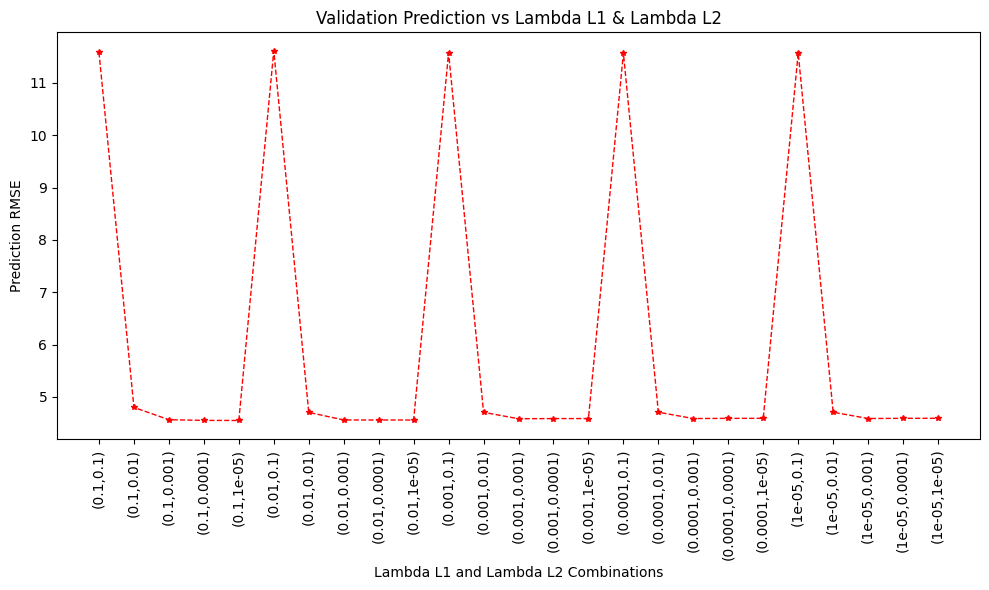

lambda_regs: (0.1,0.1), valid_predict: 11.583310528069909
lambda_regs: (0.1,0.01), valid_predict: 4.797585851402888
lambda_regs: (0.1,0.001), valid_predict: 4.562668230679382
lambda_regs: (0.1,0.0001), valid_predict: 4.549841691955306
lambda_regs: (0.1,1e-05), valid_predict: 4.547972905330245
lambda_regs: (0.01,0.1), valid_predict: 11.614463541709982
lambda_regs: (0.01,0.01), valid_predict: 4.702843840003277
lambda_regs: (0.01,0.001), valid_predict: 4.5582128392535175
lambda_regs: (0.01,0.0001), valid_predict: 4.5571096158486455
lambda_regs: (0.01,1e-05), valid_predict: 4.557105151249156
lambda_regs: (0.001,0.1), valid_predict: 11.57779742403611
lambda_regs: (0.001,0.01), valid_predict: 4.704495058880889
lambda_regs: (0.001,0.001), valid_predict: 4.5814586874609295
lambda_regs: (0.001,0.0001), valid_predict: 4.584453719131424
lambda_regs: (0.001,1e-05), valid_predict: 4.584923977618157
lambda_regs: (0.0001,0.1), valid_predict: 11.572614612190202
lambda_regs: (0.0001,0.01), valid_predic

In [ ]:
# import itertools
# # 創建 x 軸的標籤
# xx = [f"({l1},{l2})" for l1, l2 in itertools.product(lambda_l1s, lambda_l2s)]

# # 繪圖
# plt.figure(figsize=(10, 6))
# plt.plot(xx, valid_predict, 'r*--', linewidth=1, markersize=4)

# # 設定 x 軸標籤
# plt.xticks(rotation=90)

# # 設定標題和軸標籤
# plt.title('Validation Prediction vs Lambda L1 & Lambda L2')
# plt.xlabel('Lambda L1 and Lambda L2 Combinations')
# plt.ylabel('Prediction RMSE')

# # 儲存和顯示圖形
# plt.tight_layout()  # 防止標籤重疊
# plt.savefig('../output/lambda_reg_ElasticNet.png')
# plt.show()

# # 顯示每個 lambda 組合及對應的預測值
# for i in range(len(xx)):
#     print(f"lambda_regs: {xx[i]}, valid_predict: {valid_predict[i]}")